Since the uprising of Artificial Intelligence, text classification has become one of the most staggering tasks to accomplish. In layman terms, We can say Artificial Intelligence is the field which tries to achieve human-like intelligent models to ease the jobs for all of us. We have an astounding proficiency in text classification but even many sophisticated NLP models are failed to achieve proficiency even close to it. So the question arises is that what we humans do differently? How do we classify text?

First of all, we understand words not each and every word but many of them and we can guess even unknown words just by the structure of a sentence. Then we understand the message that those series of words (sentence) conveys. Then from those series of sentences, we understand the meaning of a paragraph or an article. The similar approach is used in Hierarchical Attention model.

**To Learn Hierarchical Attention Network completely go [here](https://medium.com/@heetsankesara3/hierarchical-attention-networks-d220318cf87e)**

** Click [here](https://github.com/Hsankesara/DeepResearch/tree/master/Hierarchical_Attention_Network) to go to the code**


In [1]:
import tensorflow as tf
from tensorflow import keras


In [2]:
import pandas as pd
import numpy as np
#from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
#from keras.engine.topology import Layer
#from keras import initializers as initializers, regularizers, constraints
#from keras.callbacks import Callback, ModelCheckpoint
#from keras.utils.np_utils import to_categorical
#from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
#from keras import backend as K
#from keras import optimizers
#from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

### Attention Layer

In [3]:
class AttentionWithContext(keras.layers.Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self, init='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None,  **kwargs):
        self.supports_masking = True
        self.init = initializers.get(init)
        self.kernel_initializer = initializers.get('glorot_uniform')

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer=self.kernel_initializer,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
        self.b = self.add_weight(shape=(input_shape[1],),
                                 initializer='zero',
                                 name='{}_b'.format(self.name),
                                 regularizer=self.bias_regularizer,
                                 constraint=self.bias_constraint)

        self.u = self.add_weight(shape=(input_shape[1],),
                                 initializer=self.kernel_initializer,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
        self.built = True

    def compute_mask(self, input, mask):
        return None

    def call(self, x, mask=None):
        # (x, 40, 300) x (300, 1)
        multData =  K.dot(x, self.kernel) # (x, 40, 1)
        multData = K.squeeze(multData, -1) # (x, 40)
        multData = multData + self.b # (x, 40) + (40,)

        multData = K.tanh(multData) # (x, 40)

        multData = multData * self.u # (x, 40) * (40, 1) => (x, 1)
        multData = K.exp(multData) # (X, 1)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            mask = K.cast(mask, K.floatx()) #(x, 40)
            multData = mask*multData #(x, 40) * (x, 40, )

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        multData /= K.cast(K.sum(multData, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        multData = K.expand_dims(multData)
        weighted_input = x * multData
        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1],)

In [4]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [5]:
from tensorflow.keras import regularizers,initializers,constraints

### Config

In [6]:
max_features=200000
max_senten_len=40
max_senten_num=6
embed_size=100
VALIDATION_SPLIT = 0.2

### Data

In [7]:
from sklearn.utils import shuffle

In [8]:
df = shuffle(pd.read_json('E:/saves/News_Category_Dataset_v2.json', lines=True)).reset_index()

In [9]:
len(df.category.unique())

41

In [10]:
df.head()

,index,category,headline,authors,link,short_description,date
0,190323,WELLNESS,How I Learned to Stop Fearing My Reflection,"JJ Keith, Contributor\nAuthor of Motherhood Sm...",https://www.huffingtonpost.com/entry/body-imag...,Accepting our bodies -- and meaning it -- is h...,2012-05-20
1,59496,CRIME,Officer Captured After Shooting Spree Leaves 3...,"Sebastian Murdock, Andy Campbell, and Melissa ...",https://www.huffingtonpost.com/entry/maryland-...,"Police say Eulalio Tordil, 62, fatally shot hi...",2016-05-06
2,120318,ENTERTAINMENT,The Most Miserable 'Wheel Of Fortune' Fails Yo...,Bill Bradley,https://www.huffingtonpost.com/entry/wheel-of-...,,2014-06-12
3,42300,POLITICS,Megyn Kelly: 2016 Election Shows Women Have ‘A...,Emily Peck,https://www.huffingtonpost.com/entry/megyn-kel...,“There is tolerance for a considerable level o...,2016-11-16
4,177262,WELLNESS,Omega-3 Fatty Acid Supplements Studied To See ...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/omega-3-v...,"""It doesn't taste like medicine at all,"" he sa...",2012-10-08


In [11]:
df.category.unique()

array(['WELLNESS', 'CRIME', 'ENTERTAINMENT', 'POLITICS', 'PARENTS',
       'WORLDPOST', 'TRAVEL', 'HOME & LIVING', 'ARTS & CULTURE',
       'WEDDINGS', 'FOOD & DRINK', 'BUSINESS', 'WORLD NEWS',
       'HEALTHY LIVING', 'PARENTING', 'BLACK VOICES', 'STYLE & BEAUTY',
       'DIVORCE', 'COMEDY', 'MEDIA', 'GREEN', 'QUEER VOICES', 'GOOD NEWS',
       'MONEY', 'SPORTS', 'ARTS', 'IMPACT', 'LATINO VOICES', 'COLLEGE',
       'STYLE', 'THE WORLDPOST', 'ENVIRONMENT', 'TECH', 'WEIRD NEWS',
       'WOMEN', 'SCIENCE', 'TASTE', 'FIFTY', 'RELIGION', 'CULTURE & ARTS',
       'EDUCATION'], dtype=object)

In [12]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [13]:
df.head()

,index,category,headline,authors,link,short_description,date
0,190323,WELLNESS,How I Learned to Stop Fearing My Reflection,"JJ Keith, Contributor\nAuthor of Motherhood Sm...",https://www.huffingtonpost.com/entry/body-imag...,Accepting our bodies -- and meaning it -- is h...,2012-05-20
1,59496,CRIME,Officer Captured After Shooting Spree Leaves 3...,"Sebastian Murdock, Andy Campbell, and Melissa ...",https://www.huffingtonpost.com/entry/maryland-...,"Police say Eulalio Tordil, 62, fatally shot hi...",2016-05-06
2,120318,ENTERTAINMENT,The Most Miserable 'Wheel Of Fortune' Fails Yo...,Bill Bradley,https://www.huffingtonpost.com/entry/wheel-of-...,,2014-06-12
3,42300,POLITICS,Megyn Kelly: 2016 Election Shows Women Have ‘A...,Emily Peck,https://www.huffingtonpost.com/entry/megyn-kel...,“There is tolerance for a considerable level o...,2016-11-16
4,177262,WELLNESS,Omega-3 Fatty Acid Supplements Studied To See ...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/omega-3-v...,"""It doesn't taste like medicine at all,"" he sa...",2012-10-08


In [14]:
df['text'] = df['headline'] +'. ' +df['short_description']

In [15]:
df.head()

,index,category,headline,authors,link,short_description,date,text
0,190323,WELLNESS,How I Learned to Stop Fearing My Reflection,"JJ Keith, Contributor\nAuthor of Motherhood Sm...",https://www.huffingtonpost.com/entry/body-imag...,Accepting our bodies -- and meaning it -- is h...,2012-05-20,How I Learned to Stop Fearing My Reflection. A...
1,59496,CRIME,Officer Captured After Shooting Spree Leaves 3...,"Sebastian Murdock, Andy Campbell, and Melissa ...",https://www.huffingtonpost.com/entry/maryland-...,"Police say Eulalio Tordil, 62, fatally shot hi...",2016-05-06,Officer Captured After Shooting Spree Leaves 3...
2,120318,ENTERTAINMENT,The Most Miserable 'Wheel Of Fortune' Fails Yo...,Bill Bradley,https://www.huffingtonpost.com/entry/wheel-of-...,,2014-06-12,The Most Miserable 'Wheel Of Fortune' Fails Yo...
3,42300,POLITICS,Megyn Kelly: 2016 Election Shows Women Have ‘A...,Emily Peck,https://www.huffingtonpost.com/entry/megyn-kel...,“There is tolerance for a considerable level o...,2016-11-16,Megyn Kelly: 2016 Election Shows Women Have ‘A...
4,177262,WELLNESS,Omega-3 Fatty Acid Supplements Studied To See ...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/omega-3-v...,"""It doesn't taste like medicine at all,"" he sa...",2012-10-08,Omega-3 Fatty Acid Supplements Studied To See ...


In [16]:
df = df[['text', 'category']]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
text        200853 non-null object
category    200853 non-null object
dtypes: object(2)
memory usage: 3.1+ MB


In [18]:
categories = df['category']
text = df['text']

In [19]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 40
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int

In [20]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [21]:
paras = []
labels = []
texts = []

In [22]:
sent_lens = []
sent_nums = []
for idx in range(df.text.shape[0]):
    text = clean_str(df.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(tf.keras.preprocessing.text.text_to_word_sequence(sent)))
    paras.append(sentences)

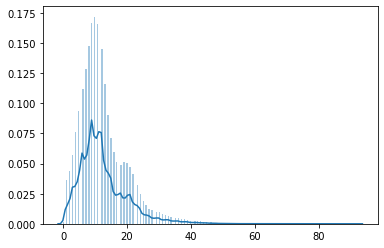

In [23]:
sns.distplot(sent_lens, bins=200)
plt.show()

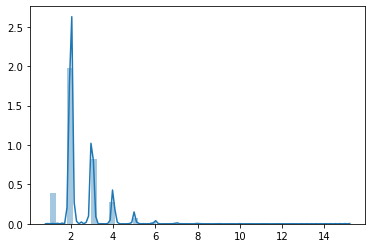

In [24]:
sns.distplot(sent_nums)
plt.show()

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [26]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens =tf.keras.preprocessing.text.text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

bob mcdonnell
but if
the hamilton creator
at johansson
and its
— david
gratisography


In [27]:
data.shape

(200853, 6, 40)

In [28]:
data

array([[[   35,    14,   556, ...,     0,     0,     0],
        [ 4107,    38,  1804, ...,     0,     0,     0],
        [   14,    91,    93, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[ 1253,  3599,    62, ...,     0,     0,     0],
        [  225,   119, 44822, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    2,    68,  5762, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     

In [29]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 100266 unique tokens.


In [30]:
labels = pd.get_dummies(categories)

In [31]:
labels

,ARTS,ARTS & CULTURE,BLACK VOICES,BUSINESS,COLLEGE,COMEDY,CRIME,CULTURE & ARTS,DIVORCE,EDUCATION,...,STYLE & BEAUTY,TASTE,TECH,TRAVEL,WEDDINGS,WEIRD NEWS,WELLNESS,WOMEN,WORLD NEWS,WORLDPOST
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200850,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [32]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (200853, 6, 40)
Shape of labels tensor: (200853, 40)


In [33]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
#labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']
[1209, 1086, 3583, 4770, 868, 4143, 2770, 811, 2764, 795, 12853, 1067, 1101, 4965, 1105, 2125, 5334, 3362, 2762, 915, 2208, 1365, 6904, 3147, 26171, 5041, 2047, 1744, 3899, 1837, 7723, 1676, 1673, 7963, 2927, 2159, 14235, 2784, 1764, 5028]
[300, 253, 945, 1167, 276, 1032, 635, 219, 662, 209, 3205, 256, 300, 1261, 293, 497, 1360, 833, 697, 214, 607, 342, 1773, 808, 6568, 1273, 509, 434, 985, 417, 1926, 420, 409, 1924, 724, 511, 3

In [34]:
indices

array([164350,  21391, 118505, ...,  57646,  39232,  17934])

### Model

In [35]:
REG_PARAM = 1e-13
l2_reg = tf.keras.regularizers.l2(REG_PARAM)

In [36]:
x_train

array([[[ 1664,  2458,  2773, ...,     0,     0,     0],
        [ 2273,     5, 10661, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  319,  1331,    13, ...,     0,     0,     0],
        [   11,    17,    63, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[ 6158,  2703,  5675, ...,     0,     0,     0],
        [    2,   820,     8, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     

In [37]:
import os

In [38]:
GLOVE_DIR = "E:/glove/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [39]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 27655 which is 27.58 % of total words


In [40]:
embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [76]:
word_input = tf.keras.layers.Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = tf.keras.layers.TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = tf.keras.layers.TimeDistributed(wordEncoder)(sent_input)
sent_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = tf.keras.layers.TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = tf.keras.layers.Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(40, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [42]:
from tensorflow.keras.layers import LSTM,Dense

In [44]:
from tensorflow.keras import backend as K

In [50]:
from tensorflow.keras import Model,Input

ImportError: cannot import name 'TimeDistributed' from 'tensorflow_core.keras' (C:\Users\jitesh\Anaconda3\lib\site-packages\tensorflow_core\python\keras\api\_v2\keras\__init__.py)

In [57]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model1.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [58]:
y_val.iloc[:1]




,ARTS,ARTS & CULTURE,BLACK VOICES,BUSINESS,COLLEGE,COMEDY,CRIME,CULTURE & ARTS,DIVORCE,EDUCATION,...,STYLE & BEAUTY,TASTE,TECH,TRAVEL,WEDDINGS,WEIRD NEWS,WELLNESS,WOMEN,WORLD NEWS,WORLDPOST
160683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [80]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=, batch_size=512, callbacks=[checkpoint])

SyntaxError: invalid syntax (<ipython-input-80-a29bbac1a6e3>, line 1)

In [72]:
from tensorflow import keras

In [74]:
model2=keras.models.load_model("han.h5",custom_objects={'AttentionWithContext': AttentionWithContext})

ValueError: Shapes (200, 1) and (200, 200) are incompatible

In [ ]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = K.dot(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [ ]:
import tf.keras.Model

## Plotting time

In [ ]:
print(history.history.keys())

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('han.h5')